In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ml-olympiad-tfugsurabaya-2024/sample_submission.csv
/kaggle/input/ml-olympiad-tfugsurabaya-2024/test.tsv
/kaggle/input/ml-olympiad-tfugsurabaya-2024/train.tsv


In [2]:
import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")

In [3]:
pip install transformers

Note: you may need to restart the kernel to use updated packages.


# BERT Model (Multi-lingual)

In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertForSequenceClassification,AdamW
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from tqdm import tqdm

# Load the dataset
train_file = "/kaggle/input/ml-olympiad-tfugsurabaya-2024/train.tsv"
test_file = "/kaggle/input/ml-olympiad-tfugsurabaya-2024/test.tsv"

# Read training data
train_data = pd.read_csv(train_file, sep='\t')
reviews = train_data['REVIEW'].values
labels = train_data['LABEL'].values
labels-=1

# Load BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')

# Tokenize the text
input_ids = []
attention_masks = []

for review in reviews:
    encoded_dict = tokenizer.encode_plus(
                        review,
                        add_special_tokens = True,
                        max_length = 256,
                        truncation=True,
                        pad_to_max_length = True,
                        return_attention_mask = True,
                        return_tensors = 'pt'
                   )
    input_ids.append(encoded_dict['input_ids'])
    attention_masks.append(encoded_dict['attention_mask'])

input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

# Split data into train and validation sets
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels, random_state=42, test_size=0.1)
train_masks, validation_masks, _, _ = train_test_split(attention_masks, labels, random_state=42, test_size=0.1)

# Create DataLoader for training
batch_size = 16

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Create DataLoader for validation
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

In [5]:
import torch

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
import matplotlib.pyplot as plt

# Initialize empty list to store validation accuracy values
validation_accuracy_values1 = []
loss_values1=[]
# Use mixed precision training (optional)
from torch.cuda.amp import autocast, GradScaler

scaler = GradScaler()
# Load pre-trained BERT model and move it to the GPU
model1 = BertForSequenceClassification.from_pretrained(
    "bert-base-multilingual-cased", 
    num_labels = 5, 
    output_attentions = False, 
    output_hidden_states = False
).to(device)

# Move input data to the GPU
train_inputs = train_inputs.to(device)
train_masks = train_masks.to(device)
train_labels = train_labels.to(device)

validation_inputs = validation_inputs.to(device)
validation_masks = validation_masks.to(device)
validation_labels = validation_labels.to(device)

# Move optimizer to the GPU
optimizer = AdamW(model1.parameters(), lr = 2e-5, eps = 1e-8)
epochs=25

model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [7]:
# Training loop
for epoch in range(epochs):
    model1.train()
    total_train_loss = 0
    for batch in tqdm(train_dataloader, desc="Epoch {}".format(epoch + 1)):
      b_input_ids = batch[0].to(device)
      b_input_mask = batch[1].to(device)
      b_labels = batch[2].to(device)

      optimizer.zero_grad()        

      with autocast():
          outputs = model1(b_input_ids, 
                          token_type_ids=None, 
                          attention_mask=b_input_mask, 
                          labels=b_labels)
          
          loss = outputs.loss
      
      scaler.scale(loss).backward()
      scaler.step(optimizer)
      scaler.update()

    # Validation loop
    model1.eval()
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    for batch in validation_dataloader:
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        with torch.no_grad():        
            outputs = model1(b_input_ids, 
                            token_type_ids=None, 
                            attention_mask=b_input_mask,
                            labels=b_labels)
            
        loss = outputs.loss
        logits = outputs.logits

        total_eval_loss += loss.item()
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        total_eval_accuracy += np.sum(np.argmax(logits, axis=1) == label_ids)
        nb_eval_steps += 1

    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader.dataset)
    validation_accuracy_values1.append(avg_val_accuracy)
    avg_loss=total_eval_loss/len(train_dataloader)
    loss_values1.append(avg_loss)
    print("Validation Accuracy: {:.2f}".format(avg_val_accuracy))
    print("Loss: {:.2f}".format(avg_loss))

Epoch 1: 100%|██████████| 51/51 [00:13<00:00,  3.73it/s]


Validation Accuracy: 0.63
Loss: 0.13


Epoch 2: 100%|██████████| 51/51 [00:12<00:00,  3.96it/s]


Validation Accuracy: 0.65
Loss: 0.12


Epoch 3: 100%|██████████| 51/51 [00:13<00:00,  3.92it/s]


Validation Accuracy: 0.67
Loss: 0.11


Epoch 4: 100%|██████████| 51/51 [00:13<00:00,  3.83it/s]


Validation Accuracy: 0.67
Loss: 0.11


Epoch 5: 100%|██████████| 51/51 [00:13<00:00,  3.76it/s]


Validation Accuracy: 0.65
Loss: 0.13


Epoch 6: 100%|██████████| 51/51 [00:13<00:00,  3.70it/s]


Validation Accuracy: 0.64
Loss: 0.13


Epoch 7: 100%|██████████| 51/51 [00:13<00:00,  3.70it/s]


Validation Accuracy: 0.65
Loss: 0.14


Epoch 8: 100%|██████████| 51/51 [00:13<00:00,  3.76it/s]


Validation Accuracy: 0.62
Loss: 0.15


Epoch 9: 100%|██████████| 51/51 [00:13<00:00,  3.78it/s]


Validation Accuracy: 0.65
Loss: 0.17


Epoch 10: 100%|██████████| 51/51 [00:13<00:00,  3.76it/s]


Validation Accuracy: 0.62
Loss: 0.19


Epoch 11: 100%|██████████| 51/51 [00:13<00:00,  3.73it/s]


Validation Accuracy: 0.60
Loss: 0.19


Epoch 12: 100%|██████████| 51/51 [00:13<00:00,  3.71it/s]


Validation Accuracy: 0.63
Loss: 0.20


Epoch 13: 100%|██████████| 51/51 [00:13<00:00,  3.73it/s]


Validation Accuracy: 0.59
Loss: 0.22


Epoch 14: 100%|██████████| 51/51 [00:13<00:00,  3.74it/s]


Validation Accuracy: 0.65
Loss: 0.18


Epoch 15: 100%|██████████| 51/51 [00:13<00:00,  3.74it/s]


Validation Accuracy: 0.67
Loss: 0.16


Epoch 16: 100%|██████████| 51/51 [00:13<00:00,  3.74it/s]


Validation Accuracy: 0.64
Loss: 0.17


Epoch 17: 100%|██████████| 51/51 [00:13<00:00,  3.73it/s]


Validation Accuracy: 0.67
Loss: 0.20


Epoch 18: 100%|██████████| 51/51 [00:13<00:00,  3.73it/s]


Validation Accuracy: 0.62
Loss: 0.22


Epoch 19: 100%|██████████| 51/51 [00:13<00:00,  3.73it/s]


Validation Accuracy: 0.66
Loss: 0.22


Epoch 20: 100%|██████████| 51/51 [00:13<00:00,  3.73it/s]


Validation Accuracy: 0.68
Loss: 0.22


Epoch 21: 100%|██████████| 51/51 [00:13<00:00,  3.73it/s]


Validation Accuracy: 0.67
Loss: 0.22


Epoch 22: 100%|██████████| 51/51 [00:13<00:00,  3.73it/s]


Validation Accuracy: 0.66
Loss: 0.22


Epoch 23: 100%|██████████| 51/51 [00:13<00:00,  3.74it/s]


Validation Accuracy: 0.64
Loss: 0.24


Epoch 24: 100%|██████████| 51/51 [00:13<00:00,  3.73it/s]


Validation Accuracy: 0.67
Loss: 0.19


Epoch 25: 100%|██████████| 51/51 [00:13<00:00,  3.74it/s]


Validation Accuracy: 0.65
Loss: 0.22


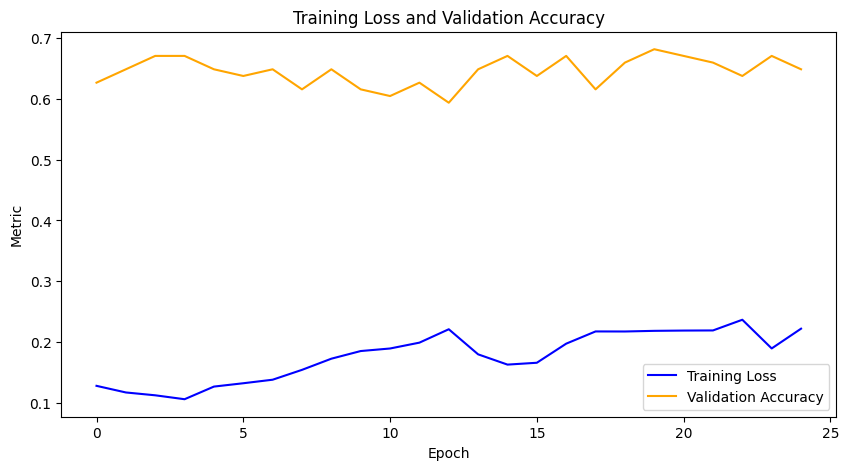

In [8]:
# Plot training loss and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(loss_values1, label='Training Loss', color='blue')
plt.plot(validation_accuracy_values1, label='Validation Accuracy', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Metric')
plt.title('Training Loss and Validation Accuracy')
plt.legend()
plt.show()

In [9]:
# Read test data
test_data = pd.read_csv(test_file, sep='\t')
test_reviews = test_data['REVIEW'].values

# Tokenize test data
test_input_ids = []
test_attention_masks = []

for review in test_reviews:
    encoded_dict = tokenizer.encode_plus(
                        review,
                        add_special_tokens = True,
                        max_length = 256,
                        pad_to_max_length = True,
                        return_attention_mask = True,
                        return_tensors = 'pt'
                   )
    test_input_ids.append(encoded_dict['input_ids'])
    test_attention_masks.append(encoded_dict['attention_mask'])

test_input_ids = torch.cat(test_input_ids, dim=0)
test_attention_masks = torch.cat(test_attention_masks, dim=0)

# Create DataLoader for test data
test_dataset = TensorDataset(test_input_ids, test_attention_masks)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

# Prediction loop
model1.eval()
predictions = []

for batch in tqdm(test_dataloader):
    b_input_ids = batch[0].to(device)
    b_input_mask = batch[1].to(device)
    
    with torch.no_grad():        
        outputs = model1(b_input_ids, 
                        token_type_ids=None, 
                        attention_mask=b_input_mask)
        
    logits = outputs.logits
    logits = logits.detach().cpu().numpy()
    predictions.extend(np.argmax(logits, axis=1))

# Convert predictions to labels
predicted_labels = [str(p + 1) for p in predictions]  # Add 1 to convert back to labels 1 to 5

# Add predicted labels to the test data
test_data['predicted_label'] = predicted_labels
test_data

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
100%|██████████| 32/32 [00:07<00:00,  4.19it/s]


,ID,REVIEW,predicted_label
0,0,"LOCATION: Letaknya di perempatan jalan, di dep...",5
1,1,"Boleh lah sesekali kesini, makanan biasa saja ...",5
2,2,Tempatnya enak biarpun tidak luas. Suasana nyaman,4
3,3,"depot bu Rudy antri, driver gojek kalau dapet ...",1
4,4,saya sering banget makan di tempat ini ...tapi...,3
...,...,...,...
495,495,"Iki yakopo seh, titik lokasimu kok nng jl ahma...",5
496,496,"Tempatnya enak, deket pintu keluar. Kalo menu ...",5
497,497,Pelayannya agak nyebelin sih,1
498,498,"Makanan nya untuk saya kurang cocok, hanya pis...",3


# RoBERTa Model

In [10]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from transformers import RobertaTokenizer, RobertaForSequenceClassification, AdamW
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from tqdm import tqdm

# Load the dataset
train_file = "/kaggle/input/ml-olympiad-tfugsurabaya-2024/train.tsv"
test_file = "/kaggle/input/ml-olympiad-tfugsurabaya-2024/test.tsv"

# Read training data
train_data = pd.read_csv(train_file, sep='\t')
reviews = train_data['REVIEW'].values
labels = train_data['LABEL'].values
labels -= 1

# Load RoBERTa tokenizer
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

# Tokenize the text
input_ids = []
attention_masks = []

for review in reviews:
    encoded_dict = tokenizer.encode_plus(
                        review,
                        add_special_tokens=True,
                        max_length=256,
                        truncation=True,
                        pad_to_max_length=True,
                        return_attention_mask=True,
                        return_tensors='pt'
                   )
    input_ids.append(encoded_dict['input_ids'])
    attention_masks.append(encoded_dict['attention_mask'])

input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

# Split data into train and validation sets
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels, random_state=42, test_size=0.1)
train_masks, validation_masks, _, _ = train_test_split(attention_masks, labels, random_state=42, test_size=0.1)

# Create DataLoader for training
batch_size = 16

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Create DataLoader for validation
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

In [11]:
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [12]:
# Initialize empty list to store validation accuracy values
validation_accuracy_values2 = []
loss_values2 = []

# Use mixed precision training (optional)
from torch.cuda.amp import autocast, GradScaler

scaler = GradScaler()

# Load pre-trained RoBERTa model and move it to the GPU
model2 = RobertaForSequenceClassification.from_pretrained(
    "roberta-base",
    num_labels=5,
    output_attentions=False,
    output_hidden_states=False
).to(device)

# Move input data to the GPU
train_inputs = train_inputs.to(device)
train_masks = train_masks.to(device)
train_labels = train_labels.to(device)

validation_inputs = validation_inputs.to(device)
validation_masks = validation_masks.to(device)
validation_labels = validation_labels.to(device)

# Move optimizer to the GPU
optimizer = AdamW(model2.parameters(), lr=2e-5, eps=1e-8)
epochs = 25

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [13]:
# Training loop
for epoch in range(epochs):
    model2.train()
    total_train_loss = 0
    for batch in tqdm(train_dataloader, desc="Epoch {}".format(epoch + 1)):
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        optimizer.zero_grad()

        with autocast():
            outputs = model2(b_input_ids,
                            attention_mask=b_input_mask,
                            labels=b_labels)

            loss = outputs.loss

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

    # Validation loop
    model2.eval()
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    for batch in validation_dataloader:
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        with torch.no_grad():
            outputs = model2(b_input_ids,
                            attention_mask=b_input_mask,
                            labels=b_labels)

        loss = outputs.loss
        logits = outputs.logits

        total_eval_loss += loss.item()
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        total_eval_accuracy += np.sum(np.argmax(logits, axis=1) == label_ids)
        nb_eval_steps += 1

    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader.dataset)
    validation_accuracy_values2.append(avg_val_accuracy)
    avg_loss = total_eval_loss / len(train_dataloader)
    loss_values2.append(avg_loss)
    print("Validation Accuracy: {:.2f}".format(avg_val_accuracy))
    print("Loss: {:.2f}".format(avg_loss))

Epoch 1: 100%|██████████| 51/51 [00:12<00:00,  4.03it/s]


Validation Accuracy: 0.63
Loss: 0.14


Epoch 2: 100%|██████████| 51/51 [00:12<00:00,  3.94it/s]


Validation Accuracy: 0.62
Loss: 0.13


Epoch 3: 100%|██████████| 51/51 [00:12<00:00,  3.99it/s]


Validation Accuracy: 0.66
Loss: 0.11


Epoch 4: 100%|██████████| 51/51 [00:12<00:00,  4.02it/s]


Validation Accuracy: 0.66
Loss: 0.11


Epoch 5: 100%|██████████| 51/51 [00:12<00:00,  4.03it/s]


Validation Accuracy: 0.68
Loss: 0.11


Epoch 6: 100%|██████████| 51/51 [00:12<00:00,  4.04it/s]


Validation Accuracy: 0.68
Loss: 0.12


Epoch 7: 100%|██████████| 51/51 [00:12<00:00,  4.01it/s]


Validation Accuracy: 0.62
Loss: 0.13


Epoch 8: 100%|██████████| 51/51 [00:12<00:00,  4.00it/s]


Validation Accuracy: 0.64
Loss: 0.13


Epoch 9: 100%|██████████| 51/51 [00:12<00:00,  4.00it/s]


Validation Accuracy: 0.56
Loss: 0.14


Epoch 10: 100%|██████████| 51/51 [00:12<00:00,  4.01it/s]


Validation Accuracy: 0.66
Loss: 0.15


Epoch 11: 100%|██████████| 51/51 [00:12<00:00,  4.03it/s]


Validation Accuracy: 0.63
Loss: 0.15


Epoch 12: 100%|██████████| 51/51 [00:12<00:00,  4.02it/s]


Validation Accuracy: 0.66
Loss: 0.16


Epoch 13: 100%|██████████| 51/51 [00:12<00:00,  4.02it/s]


Validation Accuracy: 0.65
Loss: 0.16


Epoch 14: 100%|██████████| 51/51 [00:12<00:00,  4.02it/s]


Validation Accuracy: 0.66
Loss: 0.17


Epoch 15: 100%|██████████| 51/51 [00:12<00:00,  4.01it/s]


Validation Accuracy: 0.62
Loss: 0.22


Epoch 16: 100%|██████████| 51/51 [00:12<00:00,  4.02it/s]


Validation Accuracy: 0.60
Loss: 0.19


Epoch 17: 100%|██████████| 51/51 [00:12<00:00,  4.01it/s]


Validation Accuracy: 0.64
Loss: 0.20


Epoch 18: 100%|██████████| 51/51 [00:12<00:00,  4.01it/s]


Validation Accuracy: 0.57
Loss: 0.20


Epoch 19: 100%|██████████| 51/51 [00:12<00:00,  4.00it/s]


Validation Accuracy: 0.71
Loss: 0.17


Epoch 20: 100%|██████████| 51/51 [00:12<00:00,  4.02it/s]


Validation Accuracy: 0.57
Loss: 0.23


Epoch 21: 100%|██████████| 51/51 [00:12<00:00,  4.01it/s]


Validation Accuracy: 0.59
Loss: 0.20


Epoch 22: 100%|██████████| 51/51 [00:12<00:00,  4.01it/s]


Validation Accuracy: 0.62
Loss: 0.19


Epoch 23: 100%|██████████| 51/51 [00:12<00:00,  4.02it/s]


Validation Accuracy: 0.67
Loss: 0.21


Epoch 24: 100%|██████████| 51/51 [00:12<00:00,  4.02it/s]


Validation Accuracy: 0.66
Loss: 0.20


Epoch 25: 100%|██████████| 51/51 [00:12<00:00,  4.01it/s]


Validation Accuracy: 0.67
Loss: 0.22


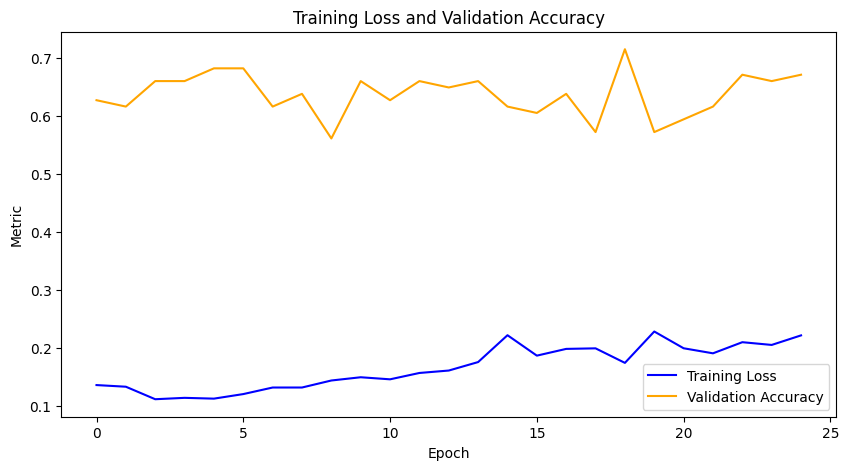

In [14]:
# Plot training loss and validation accuracy
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.plot(loss_values2, label='Training Loss', color='blue')
plt.plot(validation_accuracy_values2, label='Validation Accuracy', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Metric')
plt.title('Training Loss and Validation Accuracy')
plt.legend()
plt.show()

In [15]:
# Read test data
test_data_out = pd.read_csv(test_file, sep='\t')
test_reviews = test_data['REVIEW'].values

# Tokenize test data
test_input_ids = []
test_attention_masks = []

for review in test_reviews:
    encoded_dict = tokenizer.encode_plus(
                        review,
                        add_special_tokens = True,
                        max_length = 256,
                        pad_to_max_length = True,
                        return_attention_mask = True,
                        return_tensors = 'pt'
                   )
    test_input_ids.append(encoded_dict['input_ids'])
    test_attention_masks.append(encoded_dict['attention_mask'])

test_input_ids = torch.cat(test_input_ids, dim=0)
test_attention_masks = torch.cat(test_attention_masks, dim=0)

# Create DataLoader for test data
test_dataset = TensorDataset(test_input_ids, test_attention_masks)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

# Prediction loop
model2.eval()
predictions = []

for batch in tqdm(test_dataloader):
    b_input_ids = batch[0].to(device)
    b_input_mask = batch[1].to(device)

    with torch.no_grad():
        outputs = model2(b_input_ids,
                        token_type_ids=None,
                        attention_mask=b_input_mask)

    logits = outputs.logits
    logits = logits.detach().cpu().numpy()
    predictions.extend(np.argmax(logits, axis=1))

# Convert predictions to labels
predicted_labels = [str(p + 1) for p in predictions]  # Add 1 to convert back to labels 1 to 5

# Add predicted labels to the test data
test_data_out['predicted_label'] = predicted_labels
test_data_out

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
100%|██████████| 32/32 [00:06<00:00,  4.71it/s]


,ID,REVIEW,predicted_label
0,0,"LOCATION: Letaknya di perempatan jalan, di dep...",5
1,1,"Boleh lah sesekali kesini, makanan biasa saja ...",5
2,2,Tempatnya enak biarpun tidak luas. Suasana nyaman,5
3,3,"depot bu Rudy antri, driver gojek kalau dapet ...",2
4,4,saya sering banget makan di tempat ini ...tapi...,5
...,...,...,...
495,495,"Iki yakopo seh, titik lokasimu kok nng jl ahma...",5
496,496,"Tempatnya enak, deket pintu keluar. Kalo menu ...",5
497,497,Pelayannya agak nyebelin sih,5
498,498,"Makanan nya untuk saya kurang cocok, hanya pis...",2


# Distill BERT

In [16]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, AdamW
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from tqdm import tqdm

# Load the dataset
train_file = "/kaggle/input/ml-olympiad-tfugsurabaya-2024/train.tsv"
test_file = "/kaggle/input/ml-olympiad-tfugsurabaya-2024/test.tsv"

# Read training data
train_data = pd.read_csv(train_file, sep='\t')
reviews = train_data['REVIEW'].values
labels = train_data['LABEL'].values
labels -= 1

# Load DistilBERT tokenizer
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

# Tokenize the text
input_ids = []
attention_masks = []

for review in reviews:
    encoded_dict = tokenizer.encode_plus(
                        review,
                        add_special_tokens=True,
                        max_length=256,
                        truncation=True,
                        pad_to_max_length=True,
                        return_attention_mask=True,
                        return_tensors='pt'
                   )
    input_ids.append(encoded_dict['input_ids'])
    attention_masks.append(encoded_dict['attention_mask'])

input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

# Split data into train and validation sets
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels, random_state=42, test_size=0.1)
train_masks, validation_masks, _, _ = train_test_split(attention_masks, labels, random_state=42, test_size=0.1)

# Create DataLoader for training
batch_size = 16

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Create DataLoader for validation
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

In [17]:
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [18]:
# Initialize empty list to store validation accuracy values
validation_accuracy_values = []
loss_values = []

# Load pre-trained DistilBERT model and move it to the GPU
model = DistilBertForSequenceClassification.from_pretrained(
    "distilbert-base-uncased",
    num_labels=5,
    output_attentions=False,
    output_hidden_states=False
).to(device)

# Move input data to the GPU
train_inputs = train_inputs.to(device)
train_masks = train_masks.to(device)
train_labels = train_labels.to(device)

validation_inputs = validation_inputs.to(device)
validation_masks = validation_masks.to(device)
validation_labels = validation_labels.to(device)

# Move optimizer to the GPU
optimizer = AdamW(model.parameters(), lr=1e-5, eps=1e-8)
epochs = 25
# Implement gradient clipping
torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Clip gradients to prevent explosion

# Implement early stopping based on validation loss
best_val_loss = float('inf')
early_stopping_counter = 0
patience = 5  # Number of epochs to wait before stopping if validation loss doesn't improve

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [19]:
# Training loop
for epoch in range(epochs):
    model.train()
    total_train_loss = 0
    for batch in tqdm(train_dataloader, desc="Epoch {}".format(epoch + 1)):
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        optimizer.zero_grad()

        outputs = model(b_input_ids,
                        attention_mask=b_input_mask,
                        labels=b_labels)

        loss = outputs.loss

        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()

    # Validation loop
    model.eval()
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    for batch in validation_dataloader:
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        with torch.no_grad():
            outputs = model(b_input_ids,
                            attention_mask=b_input_mask,
                            labels=b_labels)

        loss = outputs.loss
        logits = outputs.logits

        total_eval_loss += loss.item()
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        total_eval_accuracy += np.sum(np.argmax(logits, axis=1) == label_ids)
        nb_eval_steps += 1

    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader.dataset)
    validation_accuracy_values.append(avg_val_accuracy)
    avg_loss = total_eval_loss / len(validation_dataloader)
    loss_values.append(avg_loss)
    print("Validation Accuracy: {:.2f}".format(avg_val_accuracy))
    print("Loss: {:.2f}".format(avg_loss))
    # Calculate average validation loss
    avg_val_loss = total_eval_loss / len(validation_dataloader)

    # Early stopping check
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        early_stopping_counter = 0
    else:
        early_stopping_counter += 1
        if early_stopping_counter >= patience:
            print("Validation loss hasn't improved for {} epochs. Early stopping...".format(patience))
            break


Epoch 1: 100%|██████████| 51/51 [00:17<00:00,  2.87it/s]


Validation Accuracy: 0.63
Loss: 1.12


Epoch 2: 100%|██████████| 51/51 [00:17<00:00,  2.86it/s]


Validation Accuracy: 0.63
Loss: 1.08


Epoch 3: 100%|██████████| 51/51 [00:17<00:00,  2.91it/s]


Validation Accuracy: 0.63
Loss: 1.06


Epoch 4: 100%|██████████| 51/51 [00:17<00:00,  2.92it/s]


Validation Accuracy: 0.68
Loss: 0.97


Epoch 5: 100%|██████████| 51/51 [00:17<00:00,  2.92it/s]


Validation Accuracy: 0.66
Loss: 0.97


Epoch 6: 100%|██████████| 51/51 [00:17<00:00,  2.90it/s]


Validation Accuracy: 0.68
Loss: 0.92


Epoch 7: 100%|██████████| 51/51 [00:17<00:00,  2.91it/s]


Validation Accuracy: 0.65
Loss: 0.98


Epoch 8: 100%|██████████| 51/51 [00:17<00:00,  2.91it/s]


Validation Accuracy: 0.67
Loss: 1.04


Epoch 9: 100%|██████████| 51/51 [00:17<00:00,  2.91it/s]


Validation Accuracy: 0.67
Loss: 1.01


Epoch 10: 100%|██████████| 51/51 [00:17<00:00,  2.91it/s]


Validation Accuracy: 0.65
Loss: 0.99


Epoch 11: 100%|██████████| 51/51 [00:17<00:00,  2.92it/s]


Validation Accuracy: 0.65
Loss: 1.08
Validation loss hasn't improved for 5 epochs. Early stopping...


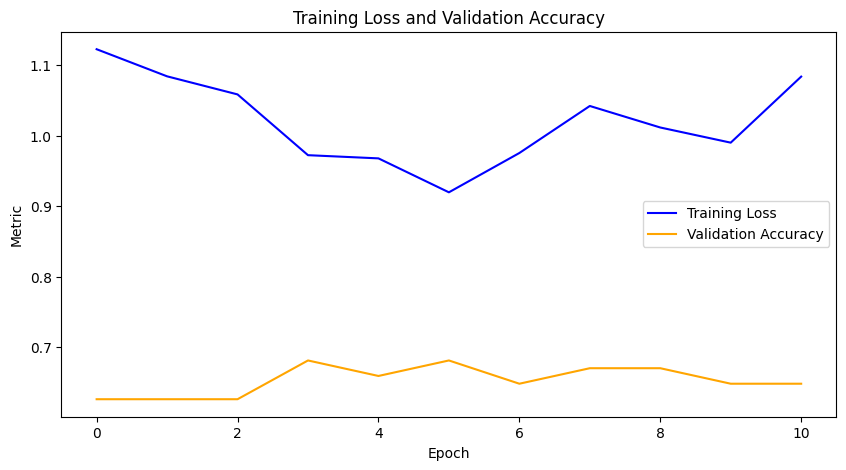

In [20]:
# Plot training loss and validation accuracy
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.plot(loss_values, label='Training Loss', color='blue')
plt.plot(validation_accuracy_values, label='Validation Accuracy', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Metric')
plt.title('Training Loss and Validation Accuracy')
plt.legend()
plt.show()

In [21]:
# Read test data
test_data = pd.read_csv(test_file, sep='\t')
test_reviews = test_data['REVIEW'].values

# Tokenize test data
test_input_ids = []
test_attention_masks = []

for review in test_reviews:
    encoded_dict = tokenizer.encode_plus(
                        review,
                        add_special_tokens = True,
                        max_length = 256,
                        pad_to_max_length = True,
                        return_attention_mask = True,
                        return_tensors = 'pt'
                   )
    test_input_ids.append(encoded_dict['input_ids'])
    test_attention_masks.append(encoded_dict['attention_mask'])

test_input_ids = torch.cat(test_input_ids, dim=0)
test_attention_masks = torch.cat(test_attention_masks, dim=0)

# Create DataLoader for test data
test_dataset = TensorDataset(test_input_ids, test_attention_masks)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

# Prediction loop
model.eval()
predictions = []

for batch in tqdm(test_dataloader):
    b_input_ids = batch[0].to(device)
    b_input_mask = batch[1].to(device)

    with torch.no_grad():
        outputs = model(b_input_ids,
                        attention_mask=b_input_mask)

    logits = outputs.logits
    logits = logits.detach().cpu().numpy()
    predictions.extend(np.argmax(logits, axis=1))

# Convert predictions to labels
predicted_labels = [str(p + 1) for p in predictions]  # Add 1 to convert back to labels 1 to 5

# Add predicted labels to the test data
test_data['predicted_label'] = predicted_labels
test_data

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
100%|██████████| 32/32 [00:03<00:00,  8.29it/s]


,ID,REVIEW,predicted_label
0,0,"LOCATION: Letaknya di perempatan jalan, di dep...",5
1,1,"Boleh lah sesekali kesini, makanan biasa saja ...",4
2,2,Tempatnya enak biarpun tidak luas. Suasana nyaman,5
3,3,"depot bu Rudy antri, driver gojek kalau dapet ...",1
4,4,saya sering banget makan di tempat ini ...tapi...,1
...,...,...,...
495,495,"Iki yakopo seh, titik lokasimu kok nng jl ahma...",5
496,496,"Tempatnya enak, deket pintu keluar. Kalo menu ...",4
497,497,Pelayannya agak nyebelin sih,5
498,498,"Makanan nya untuk saya kurang cocok, hanya pis...",1


# Performance comparison between BERT, RoBERTa, Distill BERT

In [22]:
print("Highest Validation Accuracy:\n")
print("BERT: ",max(validation_accuracy_values1))
print("RoBERTa: ",max(validation_accuracy_values2))
print("Distill BERT: ",max(validation_accuracy_values))

print("\nAverage Validation Accuracy:\n")
print("BERT: ",sum(validation_accuracy_values1)/len(validation_accuracy_values1))
print("RoBERTa: ",sum(validation_accuracy_values2)/len(validation_accuracy_values2))
print("Distill BERT: ",sum(validation_accuracy_values)/len(validation_accuracy_values))

print("\nHighest Training Loss:\n")
print("BERT: ",max(loss_values1))
print("RoBERTa: ",max(loss_values2))
print("Distill BERT: ",max(loss_values))

print("\nAverage Training Loss:\n")
print("BERT: ",sum(loss_values1)/len(loss_values1))
print("RoBERTa: ",max(loss_values2)/len(loss_values2))
print("Distill BERT: ",max(loss_values)/len(loss_values))

Highest Validation Accuracy:

BERT:  0.6813186813186813
RoBERTa:  0.7142857142857143
Distill BERT:  0.6813186813186813

Average Validation Accuracy:

BERT:  0.6448351648351646
RoBERTa:  0.6364835164835163
Distill BERT:  0.6533466533466534

Highest Training Loss:

BERT:  0.23684027615715475
RoBERTa:  0.2275755195056691
Distill BERT:  1.1225114266077678

Average Training Loss:

BERT:  0.17732110476961316
RoBERTa:  0.009103020780226763
Distill BERT:  0.1020464933279789


**From the performance evaluation, we can see that RoBERTa model possess lowest average training loss and gives a good validation accuracy. So we choose RoBERTa model to this dataset for submission.**

# Submission of RoBERTa model

In [23]:
df_sub=pd.read_csv("/kaggle/input/ml-olympiad-tfugsurabaya-2024/sample_submission.csv")
df_sub

,ID;LABEL
0,0;0
1,1;0
2,2;0
3,3;0
4,4;0
...,...
495,495;0
496,496;0
497,497;0
498,498;0


In [24]:
def submit_fun(df_sub,y_pred):
    submission_df = pd.DataFrame({'ID': test_data_out.ID, 'LABEL': y_pred})
    submission_df.to_csv('submission.csv', index=False)
    print("Your submission was successfully saved!")

In [25]:
submit_fun(df_sub,test_data_out['predicted_label'])

Your submission was successfully saved!


In [26]:
df_subbb=pd.read_csv('/kaggle/working/submission.csv')
df_subbb

,ID,LABEL
0,0,5
1,1,5
2,2,5
3,3,2
4,4,5
...,...,...
495,495,5
496,496,5
497,497,5
498,498,2
